Importing dependencies and loading the dataset

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
from xgboost import XGBClassifier, XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Path of the file to read.
data_path = "countries-aggregated_csv.csv"
# Reading the file
data = pd.read_csv(data_path )


# Checking if CUDA is available
from numba import cuda
print(f'Cuda is avaialable: {cuda.is_available()}')

Cuda is avaialable: True


## Simple Multi-Linear Regression modeling part

### Note: Multi-Linear Regression is a poor model for this type of data and should not be used. The modelling is done for testing purposes only!

Making target y and input X for the XGBRegressor model and then splitting X and y into validation and training data.

In [16]:
# Features
features = ['Confirmed', 'Recovered']
X = data[features]

# Target
y = data['Deaths']

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=1)

# Preprocessing the training data.
# Normalizing the independent variables with StandardScaler
std_scaler = StandardScaler()
train_X = std_scaler.fit_transform(train_X)
val_X = std_scaler.transform(val_X)

Search space for hyperparameters.

In [13]:
# Define the search space
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 18, 1)),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "random_state": 1,
    "seed": 0,
    "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
    "booster": "gbtree",
}

Method that trains the model with the given parameters and calculates the MAE score and returns loss, status of the model.


In [14]:
def get_params(space):
    # Inputing the parameters
    model = XGBRegressor(**space)
    
    # Evaluation set
    eval_set = [(train_X, train_y), (val_X, val_y)]

    # Fit the model on the eval_set with early stopping
    model.fit(train_X, train_y, eval_set=eval_set, eval_metric="mae", early_stopping_rounds=50, verbose=False)

    # Get model predictions
    y_pred = model.predict(val_X)

    # Calculate MAE
    mae = mean_absolute_error(val_y, y_pred)
    print(f"MAE: {mae}")

    return {'loss': mae, 'status': STATUS_OK, 'model': model}

Bayesian optimization algorithm to find the most optimized parameters for the model.

In [15]:
trials = Trials()

best_params = fmin(fn=get_params,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=30,
                   trials=trials)

MAE: 146.09109136083902                               
MAE: 84.73853860129421                                                          
MAE: 77.43838327399514                                                          
MAE: 97.39075355475067                                                         
MAE: 488.92350552822666                                                        
MAE: 80.25820110007845                                                         
MAE: 97.96113248184805                                                         
MAE: 160.2403378058738                                                         
MAE: 472.0181773691171                                                         
MAE: 66.33735187525747                                                         
MAE: 112.57565502454374                                                         
MAE: 80.95158551074188                                                          
MAE: 94.63967556708155                                       

Inputing the algorithm results to define the XGBRegressor model.

In [16]:
best_model = trials.best_trial['result']['model']
print("The best hyperparameters are:")
print(best_params)
print("\nThe best optimized model:")
print(best_model)

The best hyperparameters are:
{'gamma': 4.1529192487015, 'learning_rate': 0.23356933588702536, 'max_bin': 345.0, 'max_depth': 14.0, 'min_child_weight': 0.0, 'n_estimators': 945.0, 'reg_alpha': 0.7955416040282769, 'reg_lambda': 0.21721771149866065}

The best optimized model:
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4.1529192487015, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.23356933588702536, max_bin=345,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=0.0, missing=nan, monotone_constraints=None,
             n_estimators=945, n_jobs=None, num_parallel_tree=None

Testing how much better the optimized model is compared to the standard model.

In [17]:
# Testing the best model with the validation data
best_model.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)], eval_metric=["mae"], early_stopping_rounds=50, verbose=False)
y_pred_best = best_model.predict(val_X)
mae = mean_absolute_error(val_y, y_pred_best)
print(f"MAE_Best_Model: {mae}")

# Testing the standard model with the validation data
standard_model = XGBRegressor()
standard_model.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)], eval_metric=["mae"], early_stopping_rounds=50, verbose=False)
y_pred_std = standard_model.predict(val_X)
mae_std = mean_absolute_error(val_y, y_pred_std)
print(f"MAE_Standard_Model: {mae_std}")
print(f"MAE_Difference: {mae_std - mae}")

MAE_Best_Model: 65.02643490380201
MAE_Standard_Model: 488.9359605975645
MAE_Difference: 423.9095256937625


Checking if the model underfits or overfits.

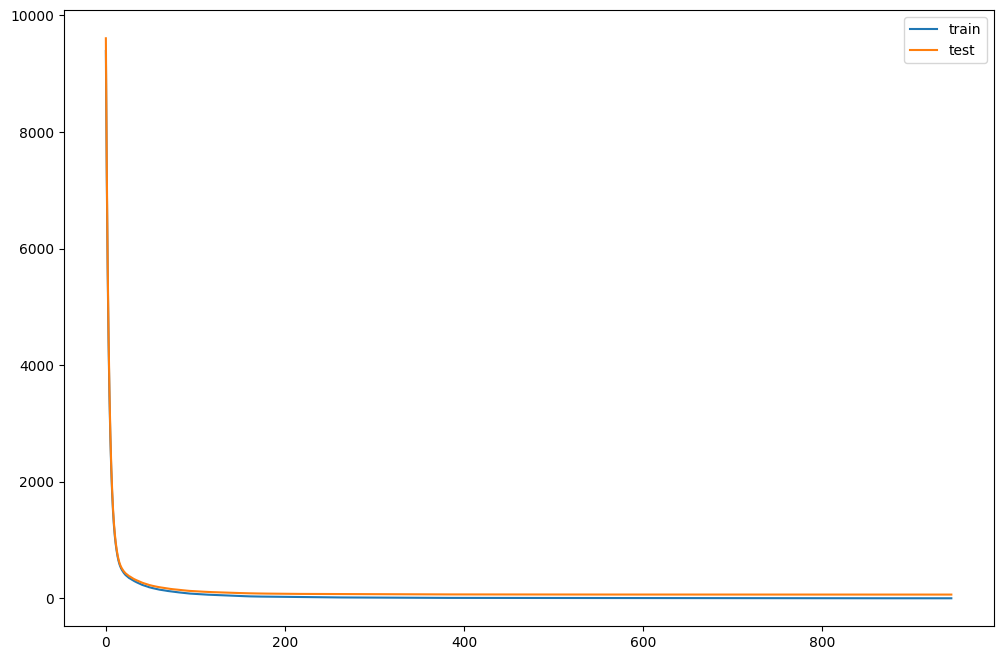

In [26]:
results = best_model.evals_result()

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='train')
plt.plot(results['validation_1']['mae'], label='test')
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

The validation and training losses seem to decrease close to zero, so the model is learning and not underfitting on both training and test cases. The losses also do not start to increase at any point, so the model does not seem to be overfitting on both training and test cases. Both plots are almost identical, so the model seems to be predicting unknown target cases quite well. We could try using different linear regression models, but XGBoost seems to do a great job with HyperOpt optimisation, so this is not necessary.

The problem with this type of modelling is that it forces all countries to fit into a simple linear regression model, which does not give us realistic or useful information because we cannot get meaningful continuous predictions for certain countries. Instead, we should try to classify the countries with the features 'confirmed', 'recovered' and 'deaths' and perhaps add some other features to the dataset that might give us more information. On the other hand, we could try to use clustering and create new classes to which each country belongs.

## Classification part

Feature engineering

Accuracy of the model is: 0.407021.


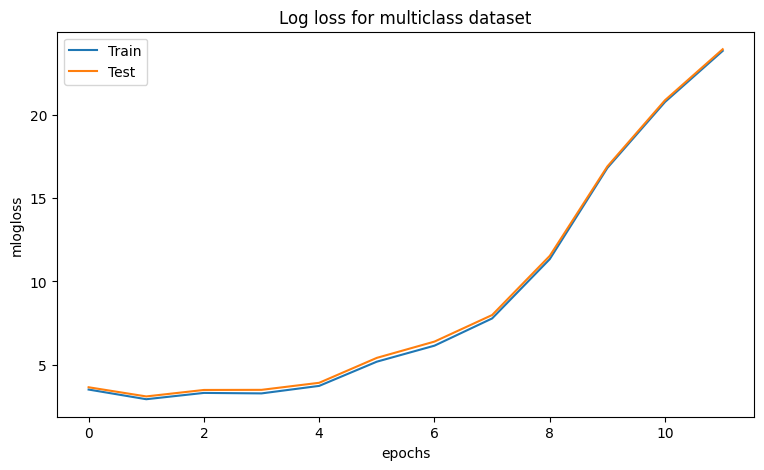

In [43]:
# Copying the data
modified_data = data.copy()

# Features
features = ['Confirmed', 'Recovered', 'Deaths']
target = 'Country'

def train_test_generator(features, target, data, stratified=False):
    # Features
    X = data[features].copy()

    # Target
    y = data[target].copy()

    # Split into validation and training data
    if stratified:
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    else:
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=42)
    

    # Preprocessing
    std_scaler = StandardScaler()
    train_X = std_scaler.fit_transform(train_X)
    val_X = std_scaler.transform(val_X)

    # Label encoding to change the target to numerical, so model can classify classes based on numbers
    label_encoder = LabelEncoder()
    train_y = label_encoder.fit_transform(train_y)
    val_y = label_encoder.transform(val_y)

    # Testing the model and getting the accuracy
    test_model(train_X, train_y, val_X, val_y)

    return None


# Testing function
def test_model(train_X, train_y, val_X, val_y):
    model = XGBClassifier(
        device='cuda',
        objective='multi:softmax',
        num_class=195,
        early_stopping_rounds=10,
        eval_metric=['merror', 'mlogloss'],
        seed=42
        )
    model.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)], verbose=False)
    y_pred = model.predict(val_X)
    accuracy = accuracy_score(y_pred, val_y)
    print(f'Accuracy of the model is: {accuracy:4f}.')

    # Plotting the performance of the model
    results = model.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)

    _, ax = plt.subplots(figsize = (9,5))
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.legend()
    plt.xlabel('epochs')
    plt.ylabel('mlogloss')
    plt.title('Log loss for multiclass dataset')
    plt.show()

    return None

# Testing the model to see what is the starting accuracy
train_test_generator(features, target, modified_data)

The standard accuracy of the model is around **0.4**, which is expected because there are only a few features and 195 classes, which makes it hard for the model to classify correctly. We can also see from the performance plot, that the model starts to **overfit** after **3** epochs, which tells us that the learning rate might be too high. There might also be unbalanced amount of classses, so let's stratify them and see if it improves the model accuracy.

Accuracy of the model is: 0.724392.


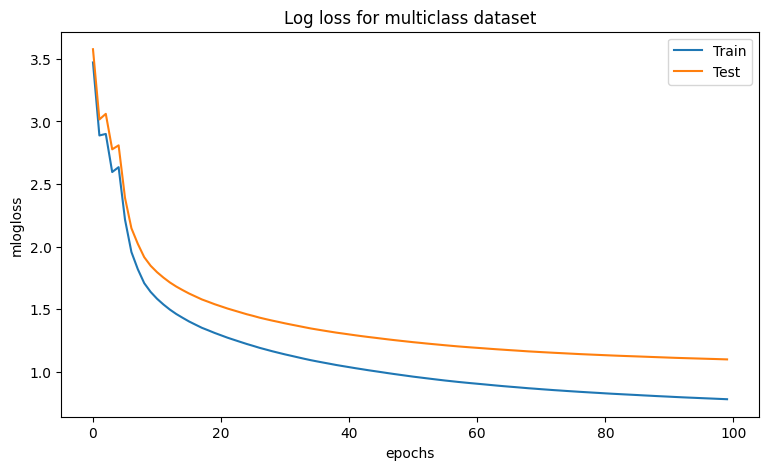

In [41]:
train_test_generator(features, target, modified_data, True)

The accuracy of the model improved a lot from **0.4** to around **0.7** accuracy after we stratified the classes, so there was some balance issues with the data classes. We can also see that the model only overfits a bit at the start, but then starts to learn. The model seems to work well with the training data, but we can see from the testing performance, that the model underfits a little bit. Let's see if adding more features will improve the accuracy of the model and help with the underfitting.

Features: ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate']
Accuracy of the model is: 0.453354.


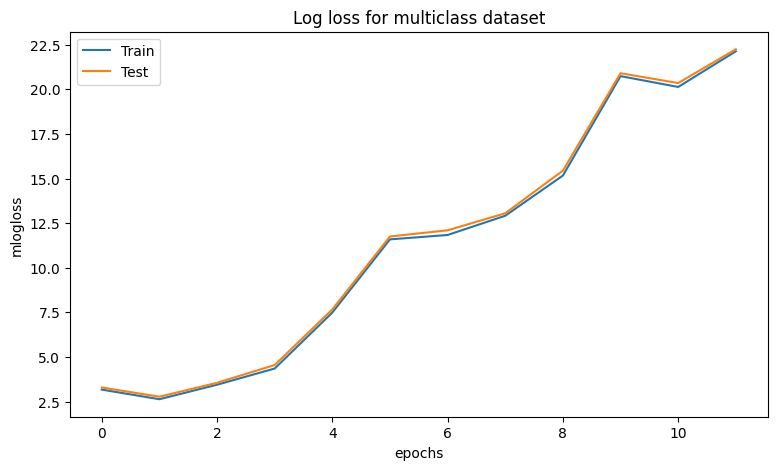



Features: ['Confirmed', 'Recovered', 'Deaths', 'Recovery_Rate']
Accuracy of the model is: 0.599615.


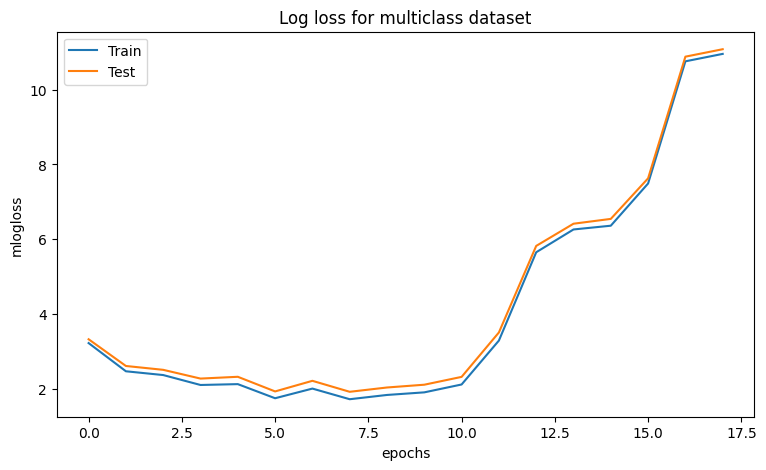



Features: ['Confirmed', 'Recovered', 'Deaths', 'Death_Recovery_Ratio']
Accuracy of the model is: 0.456556.


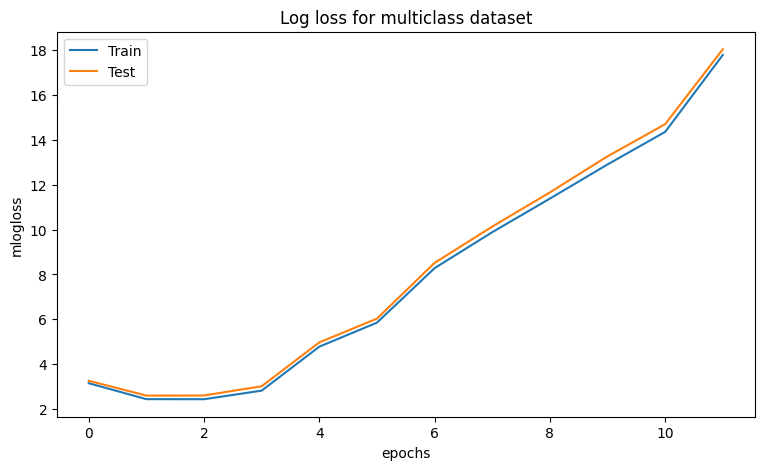



Features: ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate', 'Recovery_Rate']
Accuracy of the model is: 0.814041.


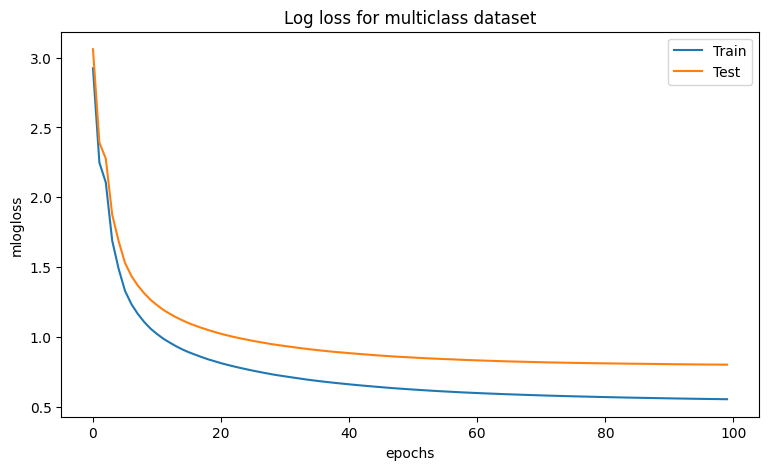



Features: ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate', 'Death_Recovery_Ratio']
Accuracy of the model is: 0.497691.


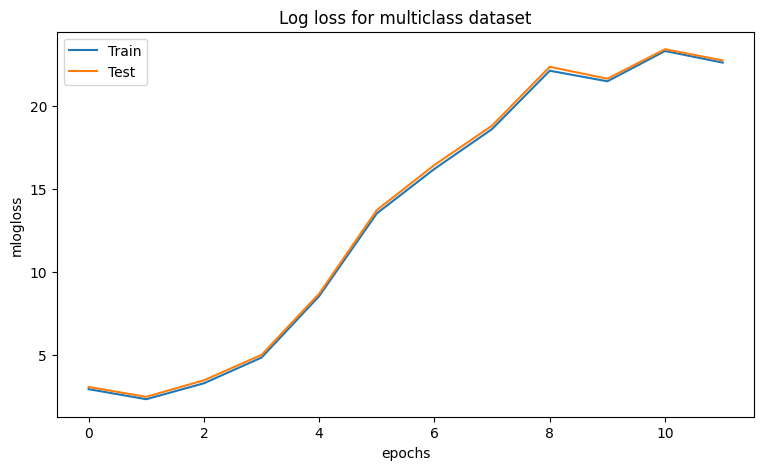



Features: ['Confirmed', 'Recovered', 'Deaths', 'Recovery_Rate', 'Death_Recovery_Ratio']
Accuracy of the model is: 0.798311.


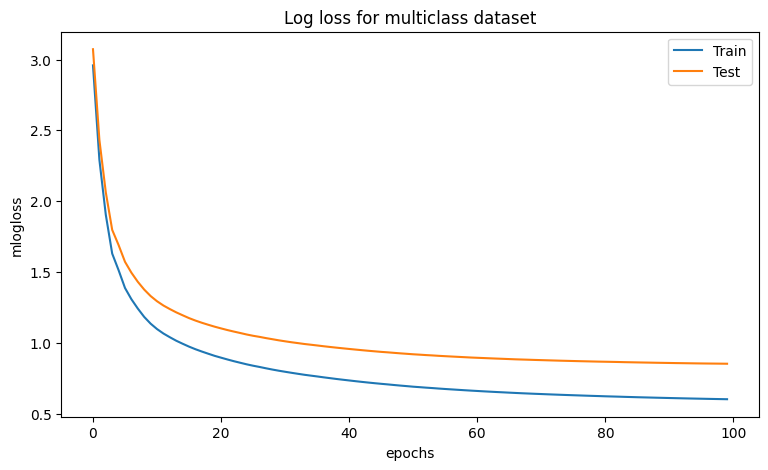



Features: ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate', 'Recovery_Rate', 'Death_Recovery_Ratio']
Accuracy of the model is: 0.499478.


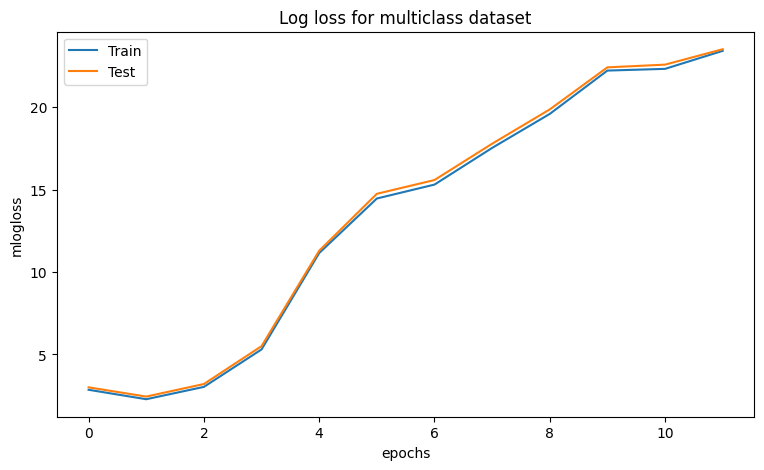

In [32]:
# Function to add new features to the dataset
def add_feature(data, feature1, feature2, new_feature):
    data[new_feature] = (data[feature1]/data[feature2])*100
    data[new_feature] = data[new_feature].fillna(data[new_feature].mean())
    data[new_feature] = data[new_feature].replace([float('inf')], 0)
    return data

# Adding new features
features_to_add = [
    ('Deaths', 'Confirmed', 'Death_Rate'),
    ('Recovered', 'Confirmed', 'Recovery_Rate'),
    ('Deaths', 'Recovered', 'Death_Recovery_Ratio')    
]

# Copying the original data to a new variable
mod_data = data.copy()

for feature1, feature2, new_feature in features_to_add:
    mod_data = add_feature(mod_data, feature1, feature2, new_feature)

# Feature lists
new_features = ['Death_Rate', 'Recovery_Rate', 'Death_Recovery_Ratio']
base_features = ['Confirmed', 'Recovered', 'Deaths']

from itertools import combinations
# Feature combinations
features = [base_features + list(comb) for i in range(1, len(new_features)+1) for comb in combinations(new_features, i)]

# Testing the model with the new feature combinations
for feature in features:
    print(f"Features: {feature}")
    train_test_generator(feature, target, mod_data, True)
    print("\n")

We can see that the accuracy of the model improved when we used **Death rate** and **Recovery rate** as features in the model for about **10 %**. When using them alone model started to overfit and lowered the accuracy of the model, so seems like together they can give some new information like we anticipated in the data analysis part.

Next, we can try to improve the model with hyperparameter tuning. We will use HyperOpt's TPE algorithm and try to improve the accuracy of the model and fix the underfitting. Let's start with defining **hyperparameter space** dictionary, **get_parameters** function and **loss_plot** function.

In [44]:
# Defining the search space. Resetting the space to the original space
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'device': 'cuda'
    # 'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    # 'gamma': hp.uniform('gamma', 1, 9),
    # "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    # "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    # "random_state": 1,
    # "seed": 0,
    # "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
    # "booster": "gbtree",
}

# Function to get the parameters
def get_parameters(space):
    # Inputing the parameters
    model = XGBClassifier(**space)
    
    # Evaluation set
    eval_set = [(train_X, train_y), (val_X, val_y)]

    # Fit the model on the eval_set with early stopping
    model.fit(train_X, train_y, eval_set=eval_set, eval_metric="mlogloss", early_stopping_rounds=10, verbose=False)

    # Get model predictions
    y_pred = model.predict(val_X)

    # Calculate accuracy
    accuracy = accuracy_score(y_pred, val_y)
    print(f"Accuracy: {accuracy}")

    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

# Log Loss plot function to show the performance of the model
def plot_results(results):
    plt.plot(results["validation_0"]["mlogloss"], label="Train")
    plt.plot(results["validation_1"]["mlogloss"], label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("mlogloss")
    plt.title("mlogloss performance of the model")
    plt.legend()
    plt.show()

### Optimization

Adding **Death rate** and **Recovery rate** to the features and **stratifying**  the target classes when splitting the data. Then scaling the features and encoding the target classes.


In [15]:
featured_data = data.copy()
featured_data = add_feature(featured_data, 'Confirmed', 'Deaths', 'Death_Rate')
featured_data = add_feature(featured_data, 'Confirmed', 'Recovered', 'Recovery_Rate')

features = ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate', 'Recovery_Rate']
target = 'Country'

X = featured_data[features].copy()
y = featured_data[target].copy()

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

std_scaler = StandardScaler()
train_X = std_scaler.fit_transform(train_X)
val_X = std_scaler.transform(val_X)

lbl_encoder = LabelEncoder()
train_y = lbl_encoder.fit_transform(train_y)
val_y = lbl_encoder.transform(val_y)

Running the optimization algorithm, so that we can possibly find more optimized hyperparameters for the model.

In [14]:
trials = Trials()

optimized_parameters = fmin(
    fn = get_parameters,
    space = space,
    algo = tpe.suggest,
    max_evals = 5,
    trials = trials
    )

optimized_model = trials.best_trial['result']['model']
print(f"Optimized model:\n{optimized_parameters}")

results = optimized_model.evals_result()
plot_results(results)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

Accuracy: 0.5862044964153964                         
Accuracy: 0.5306605415187583                                                     
Accuracy: 0.5633511983480661                                                     
Accuracy: 0.33860003248184495                                                    
Accuracy: 0.6466903320108582                                                     
100%|██████████| 5/5 [57:31<00:00, 690.22s/trial, best loss: -0.6466903320108582] 


## Change log

| Date | Version | Change Description |
| --- | --- | --- |
| 29.5.2024 | 1.0.1 | Removed variance plot. Added more descriptions. Fixed preprocessing and removed country from the feature list. Added LabelEncoder |
| 30.5.2024 | 1.0.2 | Classification part added. Feature engineering testing. Simplified variable names. Added helper functions for classification. |
| 24.7.2024 | 1.0.3 | Added stratify option and added HyperOpt optimization |